# Token Cost Analysis for Debate Run

Analyzing token counts for run: `run_20251023_144832`

Focus: EXPERT debater (correct answer) - QA response + 4 debate turns


In [1]:
import os
import re
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


In [2]:
run_dir = Path('/Users/joshlevy/projects/llm_judge_debate/parallel_debate_runs/run_20251023_144832')
log_files = sorted(run_dir.glob('log_*.txt'))
print(f"Found {len(log_files)} log files")


Found 400 log files


In [3]:
def parse_log_file(log_path):
    """Parse a log file and extract EXPERT debater's text (QA + debate turns)"""
    with open(log_path, 'r') as f:
        content = f.read()
    
    # Find which debater is correct (EXPERT)
    debater_assignments = re.search(
        r'Debater Assignments.*?Debater ([A-D]):.*?\(correct\)',
        content, re.DOTALL
    )
    if not debater_assignments:
        return None
    
    expert_letter = debater_assignments.group(1)
    
    # Extract QA reasoning
    qa_section = re.search(
        r'1\. DEBATER MODEL DIRECT QA.*?Reasoning: (.*?)\n\n',
        content, re.DOTALL
    )
    qa_text = qa_section.group(1).strip() if qa_section else ""
    
    # Extract debate turns for the expert
    debate_section = re.search(
        r'5\. LLM-JUDGED DEBATE.*?Debate Transcript:(.*?)(?:={50,}|$)',
        content, re.DOTALL
    )
    
    expert_turns = []
    if debate_section:
        debate_text = debate_section.group(1)
        # Find all turns for the expert debater
        pattern = rf'\[Debater {expert_letter}\](.*?)(?=\[Debater [A-D]\]|\[Judge\]|$)'
        turns = re.findall(pattern, debate_text, re.DOTALL)
        expert_turns = [turn.strip() for turn in turns if turn.strip()]
    
    return {
        'expert_letter': expert_letter,
        'qa_text': qa_text,
        'debate_turns': expert_turns,
        'qa_word_count': len(qa_text.split()),
        'debate_word_count': sum(len(turn.split()) for turn in expert_turns),
        'total_word_count': len(qa_text.split()) + sum(len(turn.split()) for turn in expert_turns)
    }


In [4]:
# Parse all log files
results = []
for log_file in log_files:
    parsed = parse_log_file(log_file)
    if parsed:
        results.append(parsed)

print(f"Successfully parsed {len(results)} debates")


Successfully parsed 400 debates


In [5]:
# Convert word counts to token estimates (using ~0.75 words per token)
WORDS_PER_TOKEN = 0.75

for result in results:
    result['qa_tokens'] = int(result['qa_word_count'] / WORDS_PER_TOKEN)
    result['debate_tokens'] = int(result['debate_word_count'] / WORDS_PER_TOKEN)
    result['total_tokens'] = int(result['total_word_count'] / WORDS_PER_TOKEN)


In [6]:
# Summary statistics
total_tokens_list = [r['total_tokens'] for r in results]
qa_tokens_list = [r['qa_tokens'] for r in results]
debate_tokens_list = [r['debate_tokens'] for r in results]

print("=" * 60)
print("TOKEN USAGE STATISTICS (EXPERT Debater)")
print("=" * 60)
print(f"\nTotal debates: {len(results)}")
print(f"\nQA Response Tokens:")
print(f"  Mean: {np.mean(qa_tokens_list):.0f}")
print(f"  Median: {np.median(qa_tokens_list):.0f}")
print(f"  Min: {np.min(qa_tokens_list):.0f}")
print(f"  Max: {np.max(qa_tokens_list):.0f}")
print(f"  Total: {np.sum(qa_tokens_list):.0f}")

print(f"\nDebate Turns Tokens:")
print(f"  Mean: {np.mean(debate_tokens_list):.0f}")
print(f"  Median: {np.median(debate_tokens_list):.0f}")
print(f"  Min: {np.min(debate_tokens_list):.0f}")
print(f"  Max: {np.max(debate_tokens_list):.0f}")
print(f"  Total: {np.sum(debate_tokens_list):.0f}")

print(f"\nTotal Tokens (QA + Debate):")
print(f"  Mean: {np.mean(total_tokens_list):.0f}")
print(f"  Median: {np.median(total_tokens_list):.0f}")
print(f"  Min: {np.min(total_tokens_list):.0f}")
print(f"  Max: {np.max(total_tokens_list):.0f}")
print(f"  Total: {np.sum(total_tokens_list):.0f}")
print(f"\nNote: Token estimates based on {WORDS_PER_TOKEN} words per token")


TOKEN USAGE STATISTICS (EXPERT Debater)

Total debates: 400

QA Response Tokens:
  Mean: 104
  Median: 94
  Min: 1
  Max: 428
  Total: 41466

Debate Turns Tokens:
  Mean: 257
  Median: 235
  Min: 0
  Max: 1408
  Total: 102632

Total Tokens (QA + Debate):
  Mean: 361
  Median: 338
  Min: 30
  Max: 1638
  Total: 144223

Note: Token estimates based on 0.75 words per token


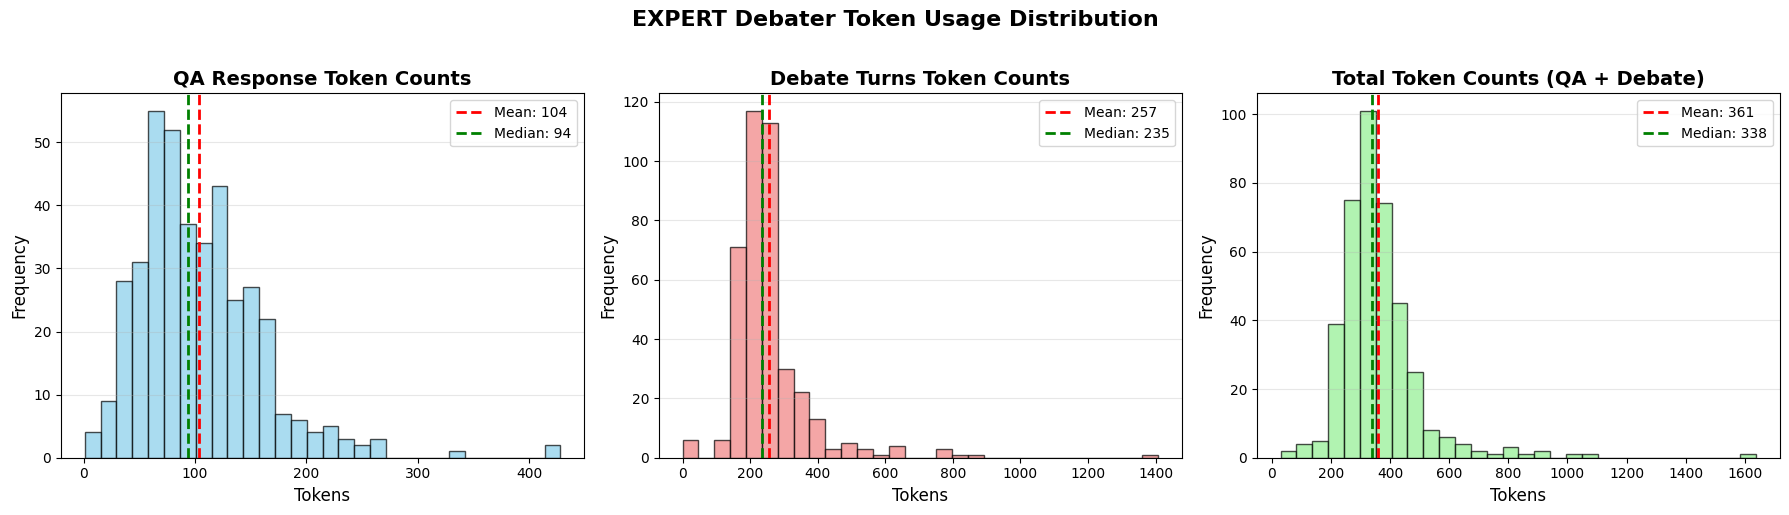

In [7]:
# Create histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# QA tokens histogram
axes[0].hist(qa_tokens_list, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(qa_tokens_list), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(qa_tokens_list):.0f}')
axes[0].axvline(np.median(qa_tokens_list), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(qa_tokens_list):.0f}')
axes[0].set_xlabel('Tokens', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('QA Response Token Counts', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Debate tokens histogram
axes[1].hist(debate_tokens_list, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(debate_tokens_list), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(debate_tokens_list):.0f}')
axes[1].axvline(np.median(debate_tokens_list), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(debate_tokens_list):.0f}')
axes[1].set_xlabel('Tokens', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Debate Turns Token Counts', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Total tokens histogram
axes[2].hist(total_tokens_list, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].axvline(np.mean(total_tokens_list), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(total_tokens_list):.0f}')
axes[2].axvline(np.median(total_tokens_list), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(total_tokens_list):.0f}')
axes[2].set_xlabel('Tokens', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Total Token Counts (QA + Debate)', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('EXPERT Debater Token Usage Distribution', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [8]:
# Check number of debate turns per debate
turn_counts = [len(r['debate_turns']) for r in results]
print(f"\nDebate turns distribution:")
for i in range(max(turn_counts) + 1):
    count = turn_counts.count(i)
    if count > 0:
        print(f"  {i} turns: {count} debates")



Debate turns distribution:
  0 turns: 6 debates
  1 turns: 394 debates


In [9]:
# Sample inspection: show a few examples
print("\n" + "="*60)
print("SAMPLE DEBATES")
print("="*60)

for i, result in enumerate(results[:3]):
    print(f"\nDebate {i+1}:")
    print(f"  Expert: Debater {result['expert_letter']}")
    print(f"  QA tokens: {result['qa_tokens']}")
    print(f"  Debate tokens: {result['debate_tokens']} ({len(result['debate_turns'])} turns)")
    print(f"  Total tokens: {result['total_tokens']}")



SAMPLE DEBATES

Debate 1:
  Expert: Debater A
  QA tokens: 148
  Debate tokens: 193 (1 turns)
  Total tokens: 341

Debate 2:
  Expert: Debater A
  QA tokens: 68
  Debate tokens: 153 (1 turns)
  Total tokens: 221

Debate 3:
  Expert: Debater A
  QA tokens: 81
  Debate tokens: 152 (1 turns)
  Total tokens: 233
